In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from torch import optim
import torch.nn.functional as F
import random
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/road_seg')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")  

In [ ]:
#Datasaet for training data
class RSDataset(Dataset):
    def __init__(self, root_dir):
        self.image_dir = root_dir + "images/"
        self.gt_dir = root_dir + "groundtruth/"
        self.root_dir = root_dir
        self.imgs = os.listdir(self.image_dir)
        self.gt = os.listdir(self.gt_dir)
        self.gt.sort()
        self.imgs.sort()
        self.size = len(self.imgs)
    
    def __len__(self):
        return self.size

    def __getitem__(self,index):

        #image processing
        img = mpimg.imread(self.image_dir + self.imgs[index])
        img = torch.tensor(img).permute(2,0,1)
        img = img.to(device)

        #mask processing
        gt_img = mpimg.imread(self.gt_dir + self.gt[index])
        gt_img = torch.tensor(gt_img)
        gt_img[gt_img < 0.5] = 0
        gt_img[gt_img > 0.5] = 1
        gt_img = gt_img.to(device)


        # Random horizontal flipping
        if random.random() > 0.5:
            img = TF.hflip(img)
            gt_img = TF.hflip(gt_img)

        # Random vertical flipping
        if random.random() > 0.5:
            img = TF.vflip(img)
            gt_img = TF.vflip(gt_img)

        return {
            'image': img,
            'target': gt_img
        }

#utils taken from class
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

In [ ]:
#Dataset for the test images
class RSTestDataset(Dataset):
    def __init__(self, root_dir):
        self.image_dir = root_dir + "test_set_images/"
        self.root_dir = root_dir
        self.imgs = os.listdir(self.image_dir)
        self.imgs.sort()
        self.size = len(self.imgs)
    
    def __len__(self):
        return self.size

    def __getitem__(self,index):
        filename = "test_{0}/test_{0}.png".format(index+1)

        #image processing
        img = mpimg.imread(self.image_dir + filename)
        img = torch.tensor(img).permute(2,0,1)
        img = img.to(device)
        

        return {
            'image': img,
            'filename': "test_{0}.png".format(index+1)
        }

In [ ]:
# root_dir must have a structure as indicated in the readme
root_dir = "drive/MyDrive/road_seg/"

#create datasets
dataset = RSDataset(root_dir)
datasetTest = RSTestDataset(root_dir)

#split into training and validation dataset
n_train = int(len(dataset) * 0.9)
n_val = len(dataset) - n_train
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=1, shuffle=True)
val_loader = DataLoader(val, batch_size=1, shuffle=True)

In [ ]:
#This cell contains all the build tools necessary for the UNet architecture
class DoubleConv(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(DoubleConv, self).__init__()
    self.layer =  nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size = 3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(True),
        nn.Conv2d(out_channel, out_channel, kernel_size = 3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(True)
    )

  def forward(self,x):
    return self.layer(x)

class Down(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(Down, self).__init__()

    self.layer = nn.Sequential(
      nn.MaxPool2d(kernel_size = 2),
      DoubleConv(in_channel, out_channel)
  )
    
  def forward(self,x):
    return self.layer(x)

class Up(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(Up, self).__init__()
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.conv = DoubleConv(in_channel, out_channel)
    
  def forward(self, x1, x2):
      x2 = self.upsample(x2)

      diffX = x1.shape[2] - x2.shape[2]
      diffY = x1.shape[3] - x2.shape[3]
      x1 = x1[:,:, diffX // 2 : x1.shape[2] - diffX // 2 - diffX % 2,:]
      x1 = x1[:,:,:, diffY // 2 : x1.shape[3] - diffY // 2 - diffY % 2]
      x = torch.cat([x1,x2], axis = 1)
      return self.conv(x)


class Unet(nn.Module):
    def __init__(self, output_channel):
        super(Unet, self).__init__()
        #_LEFT
        self.conv1 = DoubleConv(3,64)
        self.down2 = Down(64,128)
        self.down3 = Down(128,256)
        self.down4 = Down(256,512)
        self.down5 = Down(512,1024)
        
        
        #RIGHT  
        self.up6 = Up(1024+512,512)
        self.up7 = Up(512+256,256)
        self.up8 = Up(256+128,128)
        self.up9 = Up(128+64,64)
        
        #layer to match input size
        self.outConv1 = nn.Conv2d(64,64, kernel_size= 13)
        self.outConv = nn.Conv2d(64, output_channel, kernel_size = 1)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self,x):
        w,h = x.shape[2], x.shape[3]
        #DOWN DIRECTION
        x1 = self.conv1(x)
        
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x = self.down5(x4)
        
        #UP DIRECTION
        x = self.up6(x4, x)
        x = self.up7(x3, x)
        x = self.up8(x2, x)
        x = self.up9(x1, x)
        
        x = self.outConv(x)
        x = F.interpolate(x, size = (w,h))
        
        
        return x

In [ ]:
#visualize prediction for the idx sample from dataset. Threshold indicates the decision boundary between 0 and 1
def visualize(model, idx, threshold, dataset):
    sample = dataset[idx]
    with torch.no_grad():
      prediction = model(sample["image"].view(1,3,400,400))

    prediction = torch.sigmoid(prediction).squeeze(1).to(torch.device("cpu"))
    prediction[prediction > threshold] = 1
    prediction[prediction < threshold] = 0
    prediction = prediction[0].detach().numpy()
    
    input = sample["image"].to(torch.device("cpu")).permute(1,2,0).numpy()
    target = sample["target"].to(torch.device("cpu")).numpy()

    cimg = concatenate_images(input,prediction)
    cimg = concatenate_images(cimg,target)
    fig1 = plt.figure(figsize=(10, 10))
    plt.imshow(cimg, cmap='Greys_r')

#visualize prediction for the idx sample from the test dataset. Threshold indicates the decision boundary between 0 and 1
def visualizeTest(model, idx, threshold):
    sample = datasetTest[idx]
    with torch.no_grad():
      prediction = model(sample["image"].view(1,3,608,608))

    prediction = torch.sigmoid(prediction).squeeze(1).to(torch.device("cpu"))
    prediction[prediction > threshold] = 1
    prediction[prediction < threshold] = 0
    prediction = prediction[0].detach().numpy()
    
    input = sample["image"].to(torch.device("cpu")).permute(1,2,0).numpy()

    cimg = concatenate_images(input,prediction)
    fig1 = plt.figure(figsize=(10, 10))
    plt.imshow(cimg, cmap='Greys_r')

In [ ]:
#train a model, given a loss function (criterion), an optimizer, an epoch number, a training_loader and a validation_loader
def trainModel(model, criterion, optimizer, epoch, train_loader, val_loader): 
    model = model.to(device)
    print("TRAINING")
    print("EPOCH : TRA_LOSS : VAL_LOSS")
    try:
      for e in range(epoch):
          sum_loss = 0
          for batch in train_loader:
              optimizer.zero_grad()
              prediction = model(batch["image"])
              prediction = prediction.squeeze(1)
              loss = criterion(prediction, batch["target"])
              nn.utils.clip_grad_value_(model.parameters(), 0.1)
              loss.backward()
              optimizer.step()
              sum_loss += loss.item() / len(train_loader)
          loss_valid = 0
          for batch in val_loader:
            with torch.no_grad():
              prediction = model(batch["image"])
              prediction = prediction.squeeze(1)
              loss = criterion(prediction, batch["target"])
              loss_valid += loss.item() / len(val_loader)
          print("{:5} {:>10.4f} {:>10.4f}".format(e, sum_loss, loss_valid))
    except KeyboardInterrupt:
      print("Interrupted at epoch " + str(e))


In [ ]:
model = Unet(output_channel=1).to(device)
model.load_state_dict(torch.load(root_dir + "modelUnet.PTH")())

<All keys matched successfully>

In [ ]:
#training phase
lr = 1e-4
nb_epoch = 100
batch_size = 1
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr, weight_decay=1e-8)

'''
These are the line to train and save the Unet. It is commented so it does not cause problem when running the whole notebook.
Uncomment and run at your own risk, it takes lot of time and computing power
'''
#trainModel(model,criterion, optimizer, nb_epoch, train_loader, val_loader)
#torch.save(model.state_dict, root_dir + "modelUnet.PTH")

'\nThese are the line to train and save the Unet. It is commented so it does not cause problem when running the whole notebook.\nUncomment and run at your own risk, it takes lot of time and computing power\n'

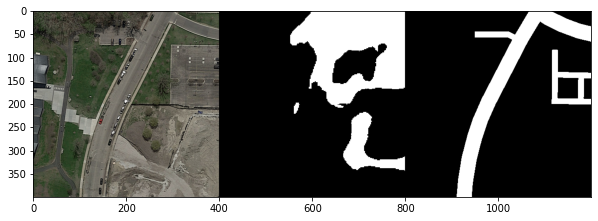

In [ ]:
#display an prediction for the validation set (index from 0 to 9)
visualize(model,6, 0.4, val)

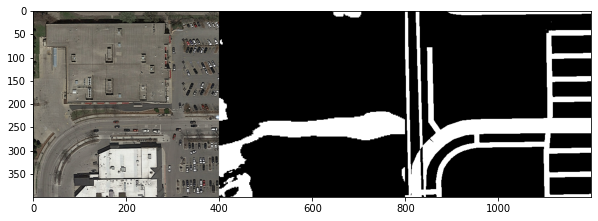

In [ ]:
#display an prediction for the training set (index from 0 to 89)
visualize(model,5, 0.4, train)

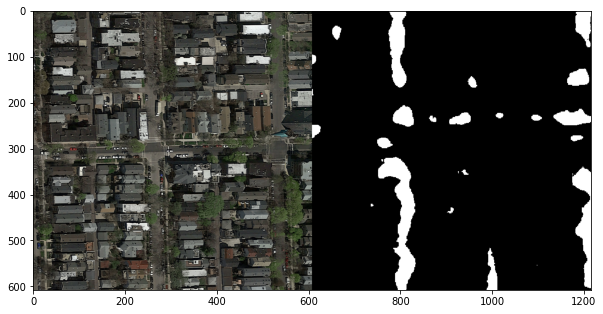

In [ ]:
#display an prediction for the training set (index from 0 to 49)
visualizeTest(model,20, 0.4)

In [ ]:
#create masks with the test images. Results in a result folder
def createMasks(model, threshold=0.3):
    for i in range(len(datasetTest)):
      sample = datasetTest[i]
      with torch.no_grad():
        prediction = model(sample["image"].view(1,3,608,608))

      prediction = torch.sigmoid(prediction).squeeze(1).to(torch.device("cpu"))
      prediction[prediction > threshold] = 1
      prediction[prediction < threshold] = 0
      prediction = prediction[0].detach().numpy()
      mpimg.imsave(root_dir + "results/" + sample['filename'], prediction, cmap='Greys_r')
createMasks(model)